# 04 Layer Sweep

Find the minimum number of layers that still learns.

**Goal:** Maximize steps/second while maintaining loss ~4.0 at step 2000.

| Run | n_layer | Hypothesis |
|-----|---------|------------|
| A | 8 | Control (~10 steps/sec, loss ~4.0) |
| B | 4 | Faster, hopefully still learns |
| C | 2 | Much faster, might be degenerate |

In [1]:
# === Parameters ===

# Fixed architecture
VOCAB_SIZE = 8192
N_EMBD = 128
N_HEAD = 2
N_POSITIONS = 512
N_INNER = 512

# Variable: layers to test
LAYER_COUNTS = [8, 4, 2]

# Training (from notebook 03)
LEARNING_RATE = 1e-4
BATCH_SIZE = 16  # Using 16 from successful diagnostic
WEIGHT_DECAY = 0.01
MAX_GRAD_NORM = 1.0
SEED = 42

# Run length
STEPS = 2000

# Paths
DATASET_PATH = "tokenized_dataset"

In [2]:
import time
import torch
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_from_disk
from transformers import (
    GPT2Config,
    GPT2LMHeadModel,
    Trainer,
    TrainingArguments,
    set_seed,
)
from transformers.trainer_callback import TrainerCallback

print("Imports complete.")

Imports complete.


In [3]:
# Load dataset
dataset = load_from_disk(DATASET_PATH)
print(f"Dataset: {len(dataset):,} sequences")

# Collator
class CausalLMCollator:
    def __call__(self, examples):
        input_ids = torch.tensor([ex["input_ids"] for ex in examples], dtype=torch.long)
        return {"input_ids": input_ids, "labels": input_ids.clone()}

collator = CausalLMCollator()

Dataset: 921,519 sequences


In [4]:
class LossTracker(TrainerCallback):
    def __init__(self):
        self.losses = []
        self.steps = []
    
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and "loss" in logs:
            self.losses.append(logs["loss"])
            self.steps.append(state.global_step)

def run_experiment(n_layer):
    """Run a single training experiment with given layer count."""
    print(f"\n{'='*50}")
    print(f"Running: n_layer = {n_layer}")
    print(f"{'='*50}")
    
    # Fresh model
    set_seed(SEED)
    config = GPT2Config(
        vocab_size=VOCAB_SIZE,
        n_embd=N_EMBD,
        n_head=N_HEAD,
        n_layer=n_layer,
        n_positions=N_POSITIONS,
        n_inner=N_INNER,
        activation_function='gelu',
        resid_pdrop=0.0,
        embd_pdrop=0.0,
        attn_pdrop=0.0,
        layer_norm_epsilon=1e-5,
        initializer_range=0.02,
        use_cache=False,
    )
    model = GPT2LMHeadModel(config)
    n_params = sum(p.numel() for p in model.parameters())
    print(f"Parameters: {n_params:,}")
    
    # Training args
    args = TrainingArguments(
        output_dir=f"sweep_layer_{n_layer}",
        overwrite_output_dir=True,
        max_steps=STEPS,
        per_device_train_batch_size=BATCH_SIZE,
        learning_rate=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY,
        max_grad_norm=MAX_GRAD_NORM,
        bf16=True,  # Proper mixed precision
        optim="adamw_torch",
        lr_scheduler_type="linear",
        warmup_steps=0,
        logging_steps=50,
        logging_first_step=True,
        report_to="none",
        save_strategy="no",
        dataloader_num_workers=0,
        seed=SEED,
    )
    
    # Train
    tracker = LossTracker()
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=dataset,
        data_collator=collator,
        callbacks=[tracker],
    )
    
    start = time.time()
    trainer.train()
    elapsed = time.time() - start
    
    steps_per_sec = STEPS / elapsed
    final_loss = tracker.losses[-1]
    
    print(f"\nResults:")
    print(f"  Time: {elapsed:.1f}s")
    print(f"  Steps/sec: {steps_per_sec:.1f}")
    print(f"  Final loss: {final_loss:.4f}")
    
    return {
        "n_layer": n_layer,
        "n_params": n_params,
        "steps_per_sec": steps_per_sec,
        "final_loss": final_loss,
        "losses": tracker.losses,
        "steps": tracker.steps,
    }

In [5]:
# Run all experiments
results = []
for n_layer in LAYER_COUNTS:
    result = run_experiment(n_layer)
    results.append(result)


Running: n_layer = 8
Parameters: 2,700,544


/Users/jefferyharrell/Workshop/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
1,9.003900
50,8.273400
100,7.445500
150,6.794000
200,6.293200
250,5.918600
300,5.614700
350,5.365000
400,5.160700
450,5.006700



Results:
  Time: 217.5s
  Steps/sec: 9.2
  Final loss: 4.0472

Running: n_layer = 4
Parameters: 1,907,456


Step,Training Loss
1,8.978700
50,8.303000
100,7.456800
150,6.795000
200,6.306100
250,5.935300
300,5.631300
350,5.382400
400,5.174100
450,5.016700



Results:
  Time: 144.1s
  Steps/sec: 13.9
  Final loss: 4.0630

Running: n_layer = 2
Parameters: 1,510,912


Step,Training Loss
1,9.002600
50,8.375100
100,7.508700
150,6.831300
200,6.319500
250,5.951500
300,5.658400
350,5.418400
400,5.217300
450,5.061200



Results:
  Time: 106.5s
  Steps/sec: 18.8
  Final loss: 4.1155


In [6]:
# Summary table
summary = pd.DataFrame([{
    "Layers": r["n_layer"],
    "Params": f"{r['n_params']/1e6:.2f}M",
    "Steps/sec": f"{r['steps_per_sec']:.1f}",
    "Final Loss": f"{r['final_loss']:.3f}",
} for r in results])

print("\n" + "="*50)
print("SUMMARY")
print("="*50)
print(summary.to_string(index=False))


SUMMARY
 Layers Params Steps/sec Final Loss
      8  2.70M       9.2      4.047
      4  1.91M      13.9      4.063
      2  1.51M      18.8      4.115


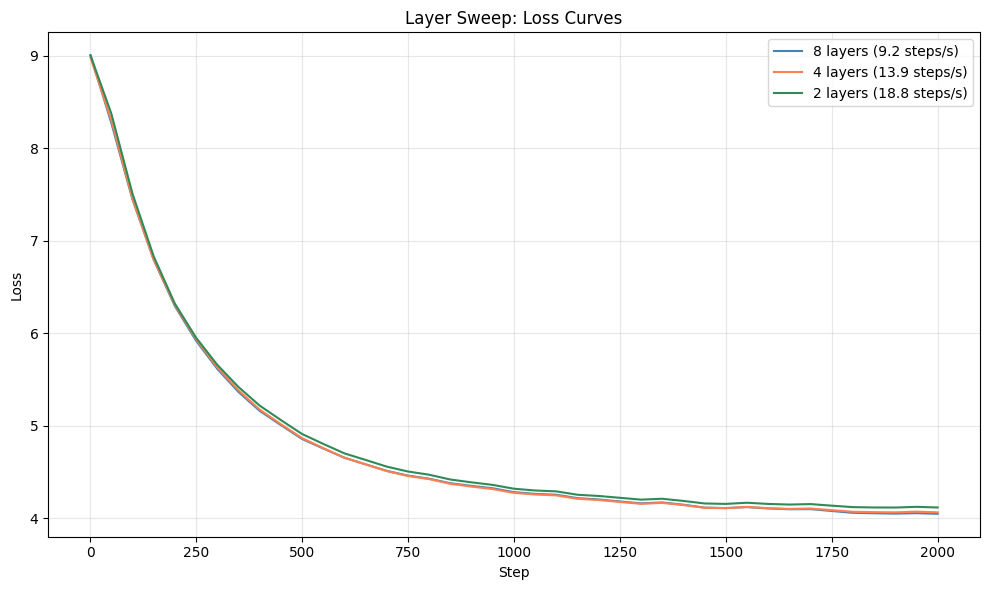

Saved: layer_sweep.png


In [7]:
# Plot loss curves
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['steelblue', 'coral', 'seagreen']
for r, color in zip(results, colors):
    ax.plot(r["steps"], r["losses"], 
            color=color, linewidth=1.5, 
            label=f"{r['n_layer']} layers ({r['steps_per_sec']:.1f} steps/s)")

ax.set_xlabel('Step')
ax.set_ylabel('Loss')
ax.set_title('Layer Sweep: Loss Curves')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('layer_sweep.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print("Saved: layer_sweep.png")

## Conclusion

Compare the three runs:
- Did 4 layers achieve similar loss to 8 layers?
- Did 2 layers degenerate or still learn?
- What's the speed/quality tradeoff?

Pick the winner for dead token recording experiments.